# Shapley Value Analysis 

Demonstrates Shapley value analysis of PDF flavours using the local `validphys.shapley` module.
Uses a small dataset mix (DIS + DY) for quick iteration.
For full-scale runs, use `scripts/run_shapley.py` with a YAML runcard.

Two perturbation bases are supported:
- **Evolution basis**: players are Sigma, g, V, T3, etc.
- **Flavor basis**: players are physical quarks/gluon, rotated before convolution.

## 1. Imports

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from validphys.shapley import (
    setup_observables,
    get_pdf_grid_values,
    get_pdf_grid_values_all14,
    gaussian_profile,
    apply_gaussian_perturbation,
    PERTURBATION_MODES,
    PERTURBATION_XSPACES,
)
from validphys.shapley.analyzer import NNPDFShapleyAnalyzer

print(f"Available perturbation modes  : {PERTURBATION_MODES}")
print(f"Available perturbation xspaces: {PERTURBATION_XSPACES}")

%matplotlib inline
plt.rcParams.update({'figure.dpi': 120})

Available perturbation modes  : ('additive', 'multiplicative')
Available perturbation xspaces: ('linear', 'logx')


## 2. Load datasets

Small mix: 3 HERA DIS + 3 hadronic DY for a quick demo.

In [33]:
datasets = [
    # DIS
    "HERA_NC_318GEV_EP-SIGMARED",
    "HERA_NC_318GEV_EM-SIGMARED",
    "HERA_CC_318GEV_EP-SIGMARED",
    # DY
    "CDF_Z0_1P96TEV_ZRAP",
    "ATLAS_Z0_7TEV_46FB_CC-Y",
    "LHCB_Z0_7TEV_DIELECTRON_Y",
]

pdf, observables, flavor_info, flavor_basis_info = setup_observables(
    pdf_name='NNPDF40_nnlo_as_01180',
    datasets=datasets,
    theory_id=708,
)

PDF set     : NNPDF40_nnlo_as_01180
Theory ID   : 708
Cut policy  : internal
Datasets    : 6

  HERA_NC_318GEV_EP-SIGMARED                     ndata= 377  nx= 50  [DIS]  fl=['\\Sigma', 'g', 'V', 'V3', 'V8', 'V15', 'T3', 'T8', 'T15']
  HERA_NC_318GEV_EM-SIGMARED                     ndata= 159  nx= 38  [DIS]  fl=['\\Sigma', 'g', 'V', 'V3', 'V8', 'V15', 'T3', 'T8', 'T15']
  HERA_CC_318GEV_EP-SIGMARED                     ndata=  39  nx= 32  [DIS]  fl=['\\Sigma', 'g', 'V', 'V3', 'V8', 'V15', 'T3', 'T8', 'T15']
  CDF_Z0_1P96TEV_ZRAP                            ndata=  28  nx= 34  [hadronic]
  ATLAS_Z0_7TEV_46FB_CC-Y                        ndata=  24  nx= 37  [hadronic]
  LHCB_Z0_7TEV_DIELECTRON_Y                      ndata=   9  nx= 41  [hadronic]

Evolution flavours used (9):
  [ 1] \Sigma
  [ 2] g
  [ 3] V
  [ 4] V3
  [ 5] V8
  [ 6] V15
  [ 9] T3
  [10] T8
  [11] T15

Physical flavours contributing (14):

  [ 0] PDG  -6  tbar
  [ 1] PDG  -5  bbar
  [ 2] PDG  -4  cbar
  [ 3] PDG  -3  sbar
  

## 3. Inspect loaded data

In [34]:
n_dis = sum(1 for o in observables if not o.hadronic)
n_had = sum(1 for o in observables if o.hadronic)
pts_dis = sum(o.ndata for o in observables if not o.hadronic)
pts_had = sum(o.ndata for o in observables if o.hadronic)

print(f"DIS datasets   : {n_dis}  ({pts_dis} pts)")
print(f"Hadronic       : {n_had}  ({pts_had} pts)")
print(f"Total          : {n_dis + n_had} datasets, {pts_dis + pts_had} pts\n")
print(f"Evolution flavours: {flavor_info['names']}")
print(f"Physical flavours : {flavor_basis_info['names']}")

DIS datasets   : 3  (575 pts)
Hadronic       : 3  (61 pts)
Total          : 6 datasets, 636 pts

Evolution flavours: ['\\Sigma', 'g', 'V', 'V3', 'V8', 'V15', 'T3', 'T8', 'T15']
Physical flavours : ['tbar', 'bbar', 'cbar', 'sbar', 'ubar', 'dbar', 'g', 'd', 'u', 's', 'c', 'b', 't', 'photon']


## 4. Predictions vs data

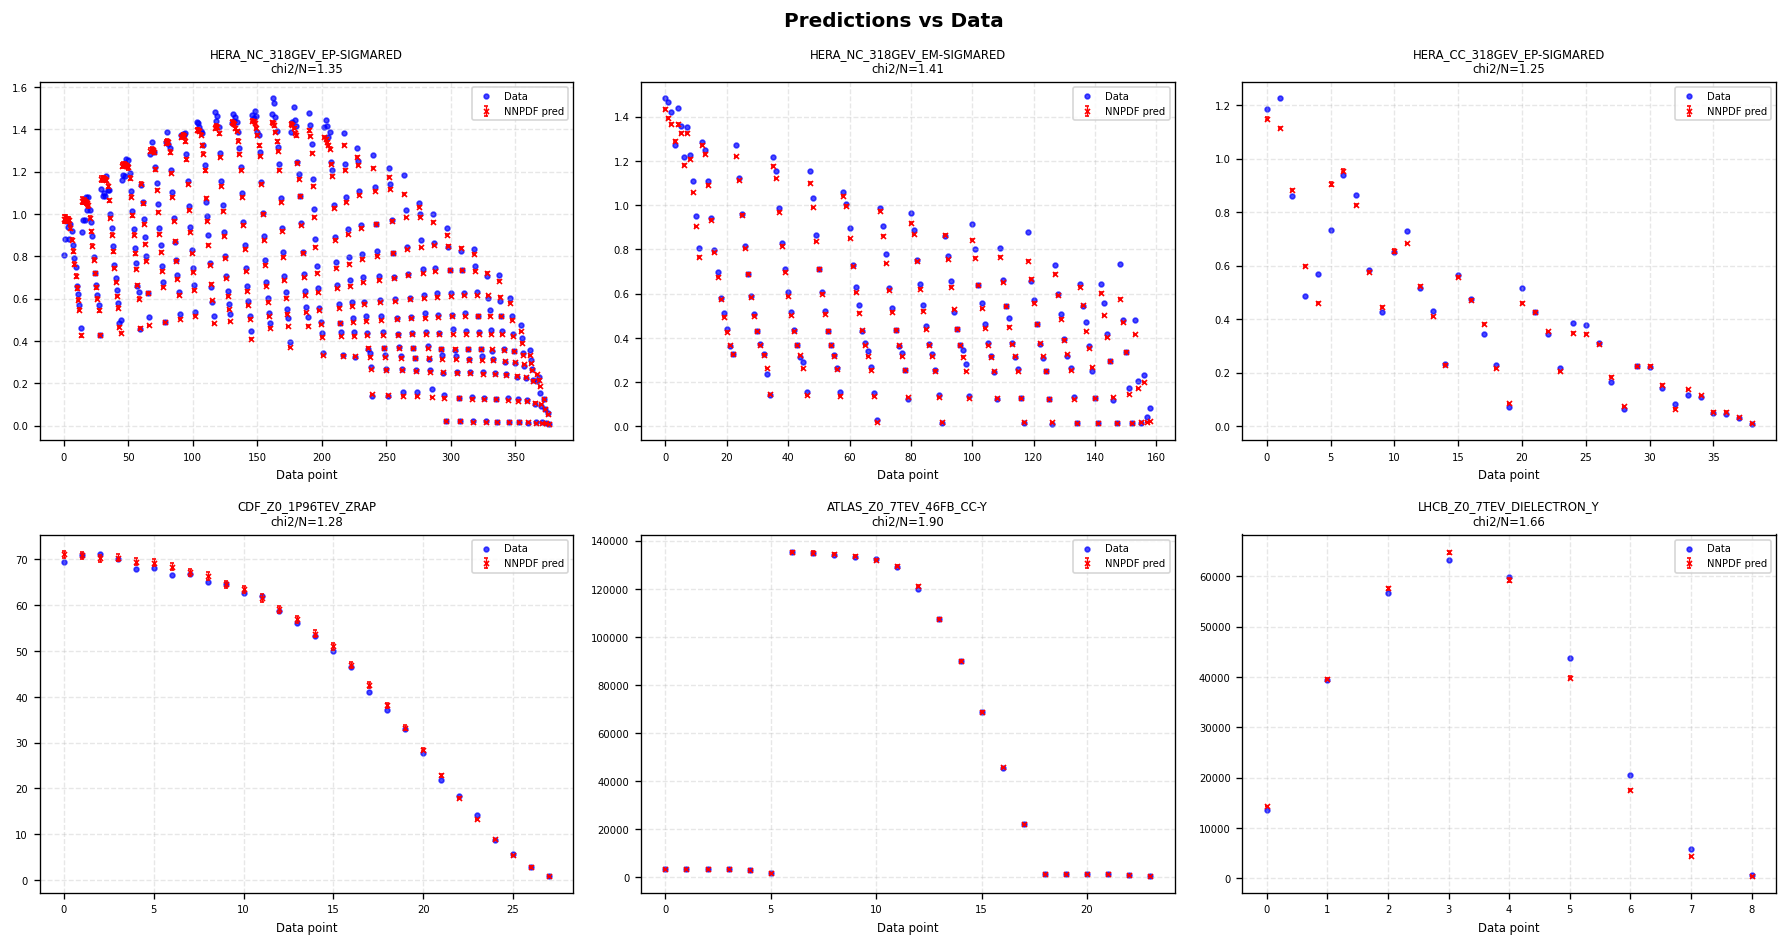

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, obs in enumerate(observables):
    ax = axes[i]
    if obs.hadronic:
        gv = get_pdf_grid_values_all14(pdf, obs, n_replicas=100)
    else:
        gv = get_pdf_grid_values(pdf, obs, n_replicas=100)
    preds = obs.convolve(gv)
    pred_mean = preds.mean(axis=1)
    pred_std = preds.std(axis=1)
    idx = np.arange(obs.ndata)

    ax.scatter(idx, obs.data_central, s=8, c='blue', alpha=0.7, label='Data')
    ax.errorbar(idx, pred_mean, yerr=pred_std, fmt='x', color='red',
                capsize=1, ms=3, lw=0.8, label='NNPDF pred')
    chi2 = obs.chi2([gv])
    ax.set_title(f"{obs.name}\nchi2/N={np.mean(chi2)/obs.ndata:.2f}", fontsize=7)
    ax.set_xlabel('Data point', fontsize=7)
    ax.tick_params(labelsize=6)
    ax.grid(True, alpha=0.3, ls='--')
    ax.legend(fontsize=6)

plt.suptitle('Predictions vs Data', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Single-flavour perturbation check

Baseline chi2/N = 1.3794

  Sigma (singlet)       delta = +0.0744
  g (gluon)             delta = -0.0036
  V (valence)           delta = +0.2965
  V3                    delta = +0.5776
  V8                    delta = +0.1191
  V15                   delta = +0.0371
  T3                    delta = +0.0028
  T8                    delta = -0.0100
  T15                   delta = +0.0342


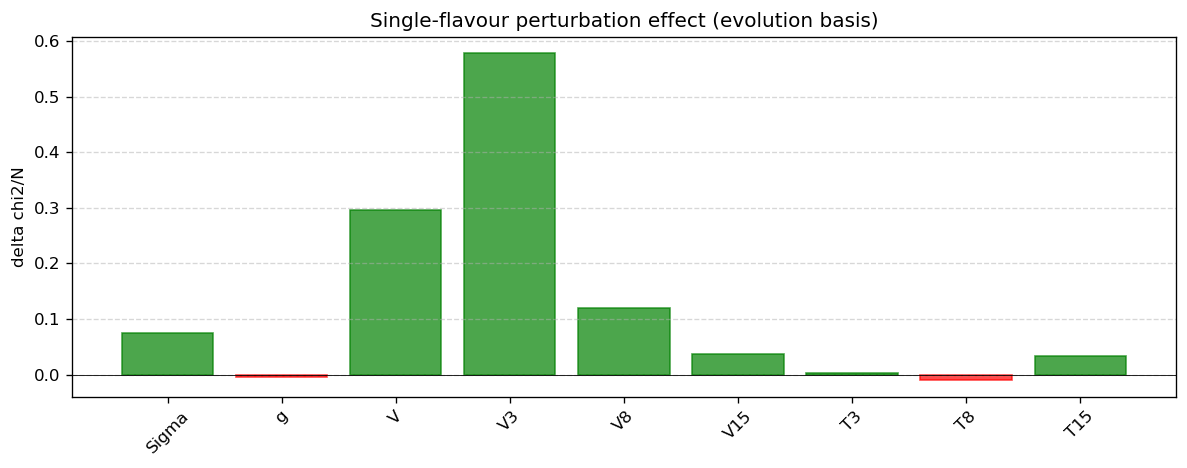

In [36]:
mu_pert, sig_pert, amp_pert = 0.02, 0.1, 0.08

analyzer = NNPDFShapleyAnalyzer(
    pdf, observables, flavor_info, n_replicas=100, enforce_sumrules=True
)

chi2_base = analyzer._evaluate_chi2([], mu_pert, sig_pert, amp_pert)
print(f"Baseline chi2/N = {chi2_base:.4f}\n")

deltas = []
for i in range(analyzer.n_flavors):
    chi2_i = analyzer._evaluate_chi2([i], mu_pert, sig_pert, amp_pert)
    d = chi2_i - chi2_base
    deltas.append(d)
    print(f"  {analyzer.flavor_labels[i]:20s}  delta = {d:+.4f}")

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(analyzer.flavor_short, deltas)
for bar, d in zip(bars, deltas):
    bar.set_color('green' if d > 0 else 'red')
    bar.set_alpha(0.7)
ax.axhline(0, color='black', lw=0.5)
ax.set_ylabel('delta chi2/N')
ax.set_title('Single-flavour perturbation effect (evolution basis)')
ax.grid(axis='y', ls='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Exact Shapley values - evolution basis

9 players --> 512 coalitions.

In [ ]:
mu_pert, sig_pert, amp_pert = 0.002, 0.001, 0.8

results = analyzer.exact_shap(mu=mu_pert, sigma=sig_pert, amplitude=amp_pert, mode='multiplicative')

Perturbation basis : evolution
Perturbation mode  : multiplicative
Perturbation xspace: linear
Sum rules          : ON
Computing exact Shapley values for 9 players (512 coalitions)...
Baseline (empty coalition) = 1.379422

  Player 0: Sigma (singlet)

## 7. Evolution-basis results

Shapley Values (evolution basis):
--------------------------------------------------
  V3      SV = +0.77472  (well-constrained)
  V       SV = +0.49735  (well-constrained)
  V15     SV = -0.33182  (poorly-constrained)
  V8      SV = +0.31175  (well-constrained)
  Sigma   SV = +0.16443  (well-constrained)
  T3      SV = +0.07680  (well-constrained)
  T8      SV = +0.02934  (well-constrained)
  T15     SV = -0.01794  (poorly-constrained)
  g       SV = -0.00035  (poorly-constrained)
--------------------------------------------------
  Baseline chi2/N = 1.3794
  Sum |SV|        = 2.20448


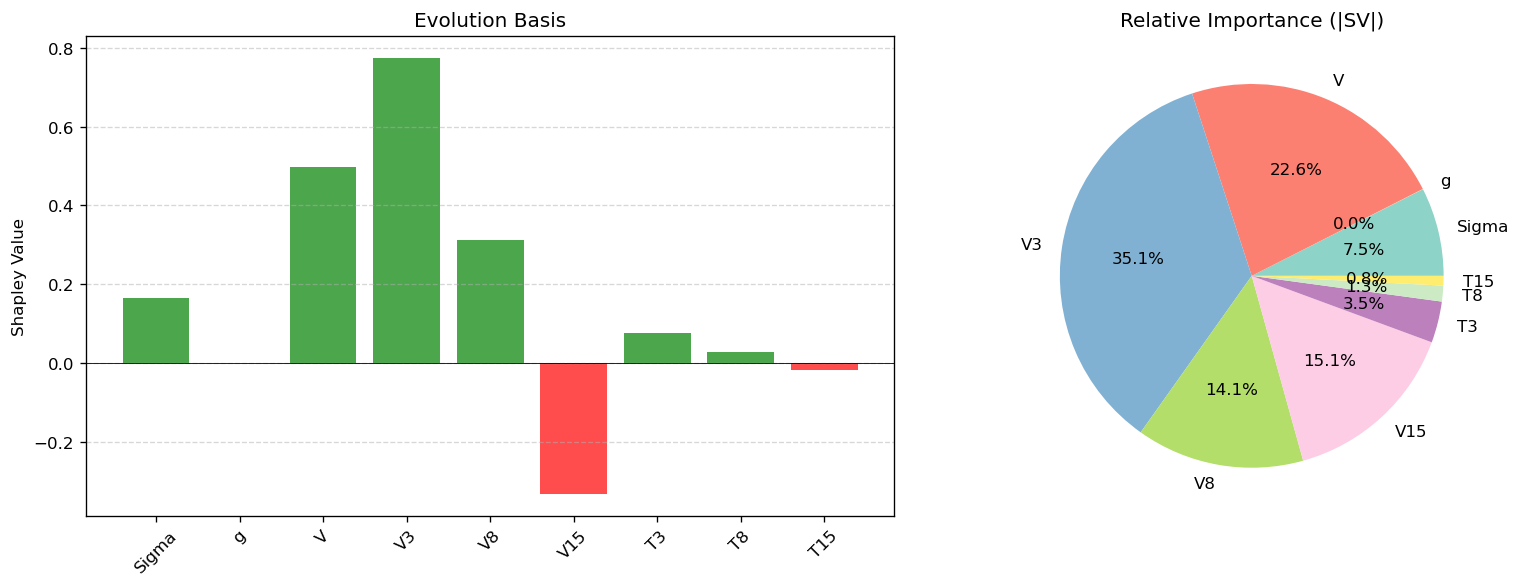

In [27]:
sv = results['shapley_values']
labels = results['flavor_short']

print("Shapley Values (evolution basis):")
print("-" * 50)
for lbl, val in sorted(zip(labels, sv), key=lambda x: -abs(x[1])):
    tag = 'well-constrained' if val > 0 else 'poorly-constrained'
    print(f"  {lbl:6s}  SV = {val:+.5f}  ({tag})")
print("-" * 50)
print(f"  Baseline chi2/N = {results['baseline_chi2']:.4f}")
print(f"  Sum |SV|        = {np.sum(np.abs(sv)):.5f}")

# Bar + pie
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = ['green' if v > 0 else 'red' for v in sv]
ax1.bar(labels, sv, color=colors, alpha=0.7)
ax1.axhline(0, color='black', lw=0.5)
ax1.set_ylabel('Shapley Value')
ax1.set_title('Evolution Basis')
ax1.grid(axis='y', ls='--', alpha=0.5)
ax1.tick_params(axis='x', rotation=45)

ax2.pie(np.abs(sv), labels=labels, autopct='%1.1f%%',
        colors=plt.cm.Set3(np.linspace(0, 1, len(labels))))
ax2.set_title('Relative Importance (|SV|)')
plt.tight_layout()
plt.show()

## 8. Exact Shapley values - flavor basis

Same datasets, but perturbations applied to physical quark flavours.

Perturbation basis : flavor
Perturbation mode  : additive
Perturbation xspace: linear
Sum rules          : OFF
Computing exact Shapley values for 9 players (512 coalitions)...
Baseline (empty coalition) = 1.379422

  Player 0: cbar  ->  SV = +0.868417
  Player 1: sbar  ->  SV = +0.200529
  Player 2: ubar  ->  SV = +0.825427
  Player 3: dbar  ->  SV = +0.220234
  Player 4: g  ->  SV = +0.010229
  Player 5: d  ->  SV = +0.204352
  Player 6: u  ->  SV = +0.786576
  Player 7: s  ->  SV = +0.199024
  Player 8: c  ->  SV = +0.868040

------------------------------------------------------------
Baseline        : 1.379422
Max |SV|        : 0.868417
Mean |SV|       : 0.464759
Sum SV          : 4.182827
Sum |SV|        : 4.182827
Elapsed         : 141.9s
------------------------------------------------------------


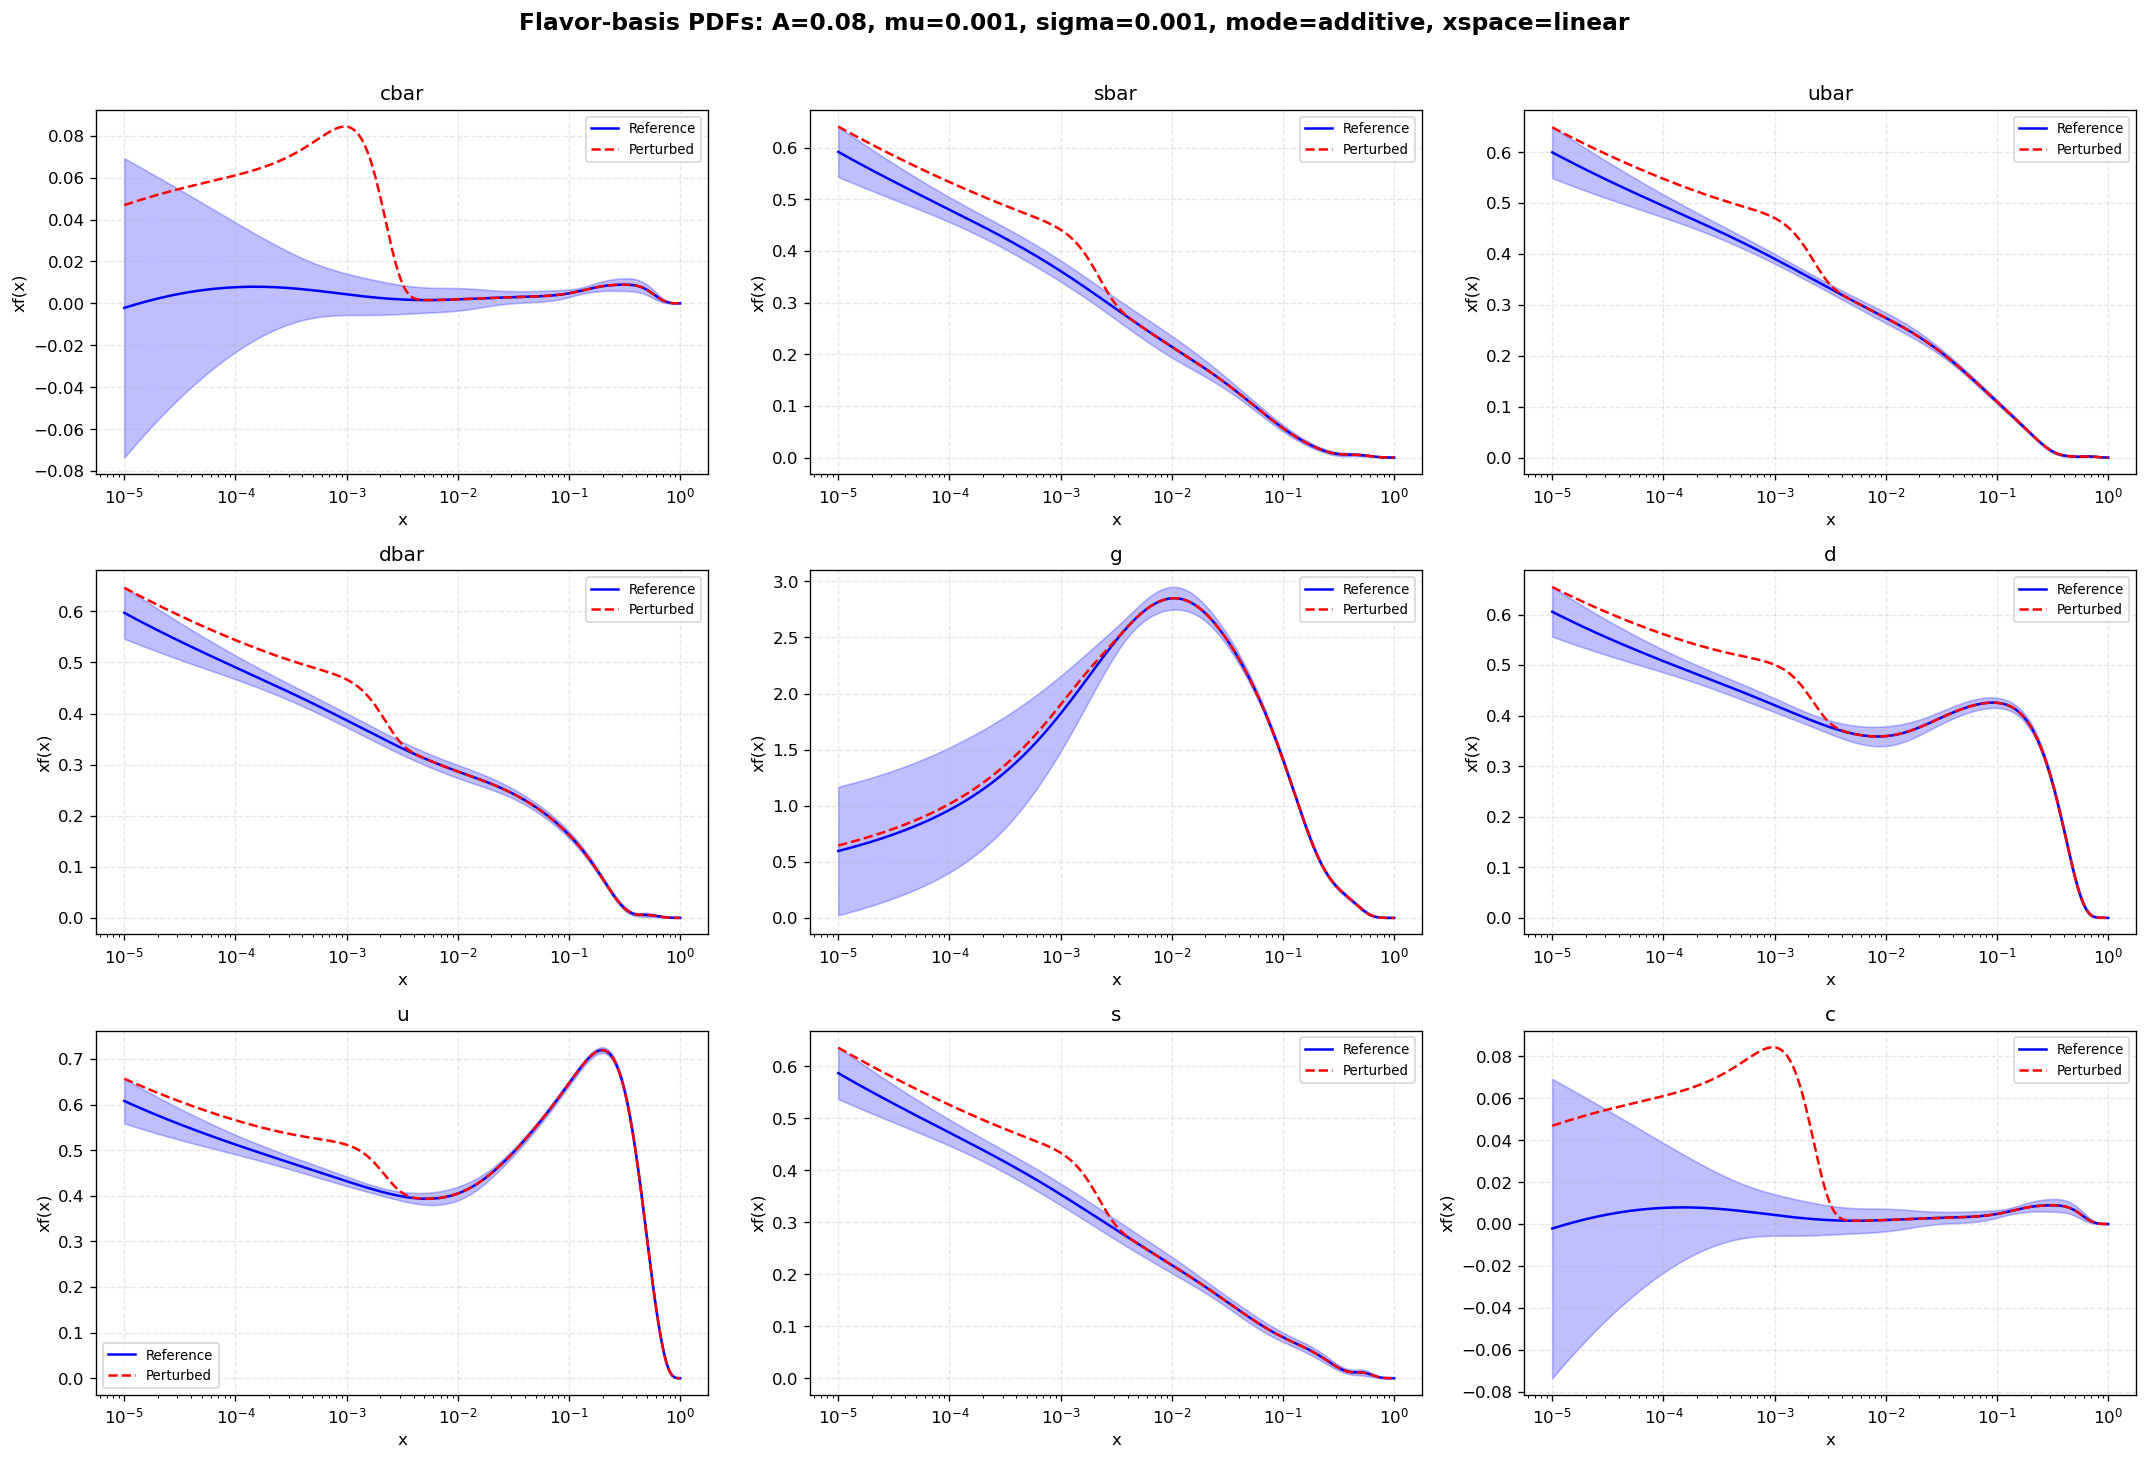

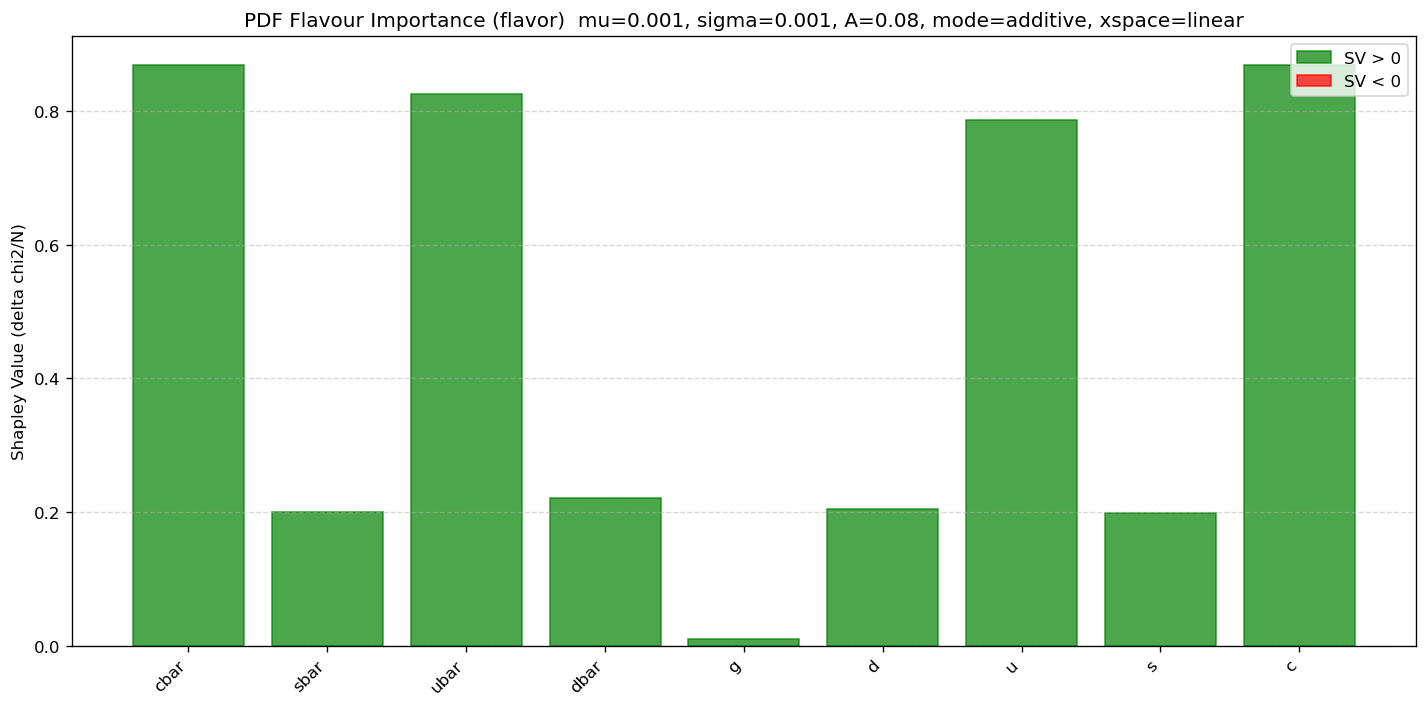

In [ ]:
flavor_9_info = {
    'indices': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'pdg_codes': [-4, -3, -2, -1, 21, 1, 2, 3, 4],
    'names': ['cbar', 'sbar', 'ubar', 'dbar', 'g', 'd', 'u', 's', 'c'],
    'n_flavors': 9,
}

analyzer_flav = NNPDFShapleyAnalyzer(
    pdf, observables, flavor_9_info,
    n_replicas=100, basis='flavor', enforce_sumrules=False
)

results_flav = analyzer_flav.exact_shap(mu=0.001, sigma=0.001, amplitude=amp_pert, mode='multiplicative')

## 9. Comparison: evolution vs flavor basis

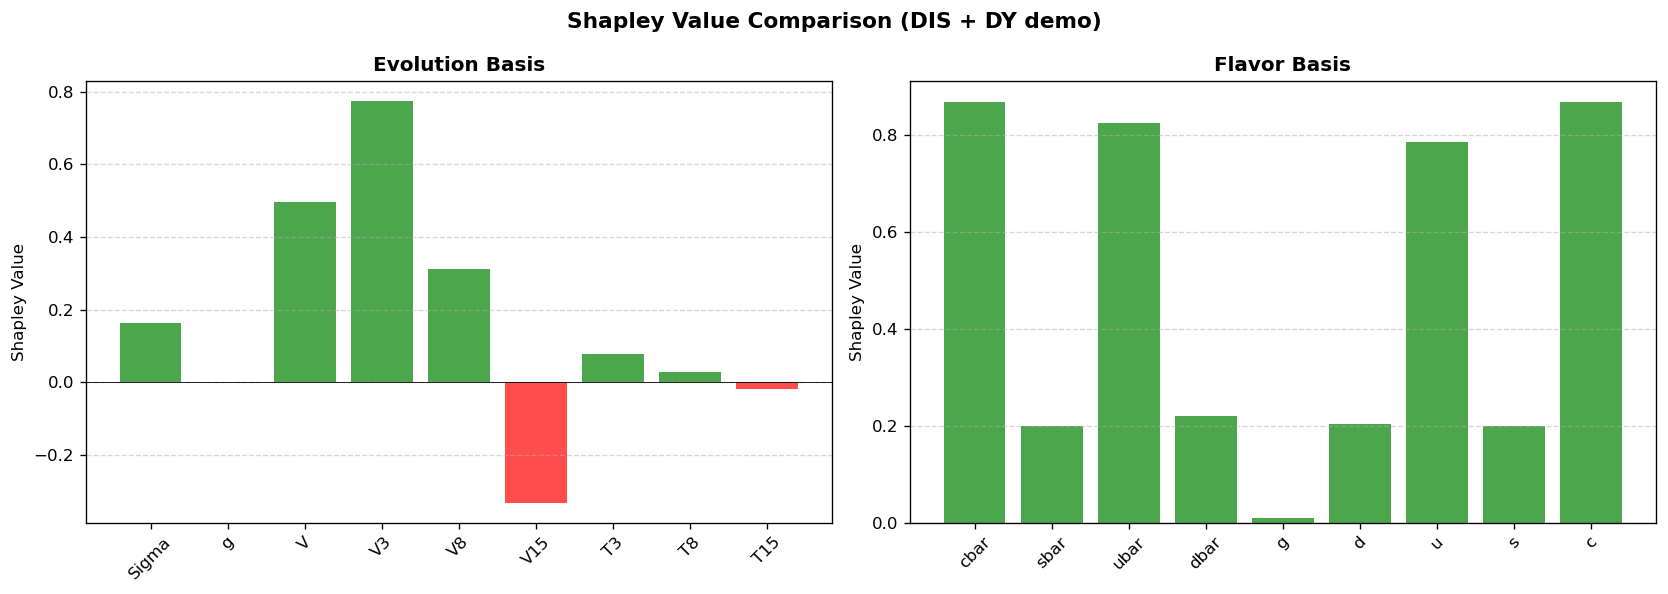

Evolution sum SV = 1.50428
Flavor sum SV    = 4.18283


In [29]:
sv_flav = results_flav['shapley_values']
labels_flav = results_flav['flavor_short']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors_ev = ['green' if v > 0 else 'red' for v in sv]
ax1.bar(labels, sv, color=colors_ev, alpha=0.7)
ax1.axhline(0, color='black', lw=0.5)
ax1.set_ylabel('Shapley Value')
ax1.set_title('Evolution Basis', fontweight='bold')
ax1.grid(axis='y', ls='--', alpha=0.5)
ax1.tick_params(axis='x', rotation=45)

colors_fl = ['green' if v > 0 else 'red' for v in sv_flav]
ax2.bar(labels_flav, sv_flav, color=colors_fl, alpha=0.7)
ax2.axhline(0, color='black', lw=0.5)
ax2.set_ylabel('Shapley Value')
ax2.set_title('Flavor Basis', fontweight='bold')
ax2.grid(axis='y', ls='--', alpha=0.5)
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Shapley Value Comparison (DIS + DY demo)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Evolution sum SV = {np.sum(sv):.5f}")
print(f"Flavor sum SV    = {np.sum(sv_flav):.5f}")

## 10. Perturbation options

Perturbations are controlled by two independent parameters: mode and xspace

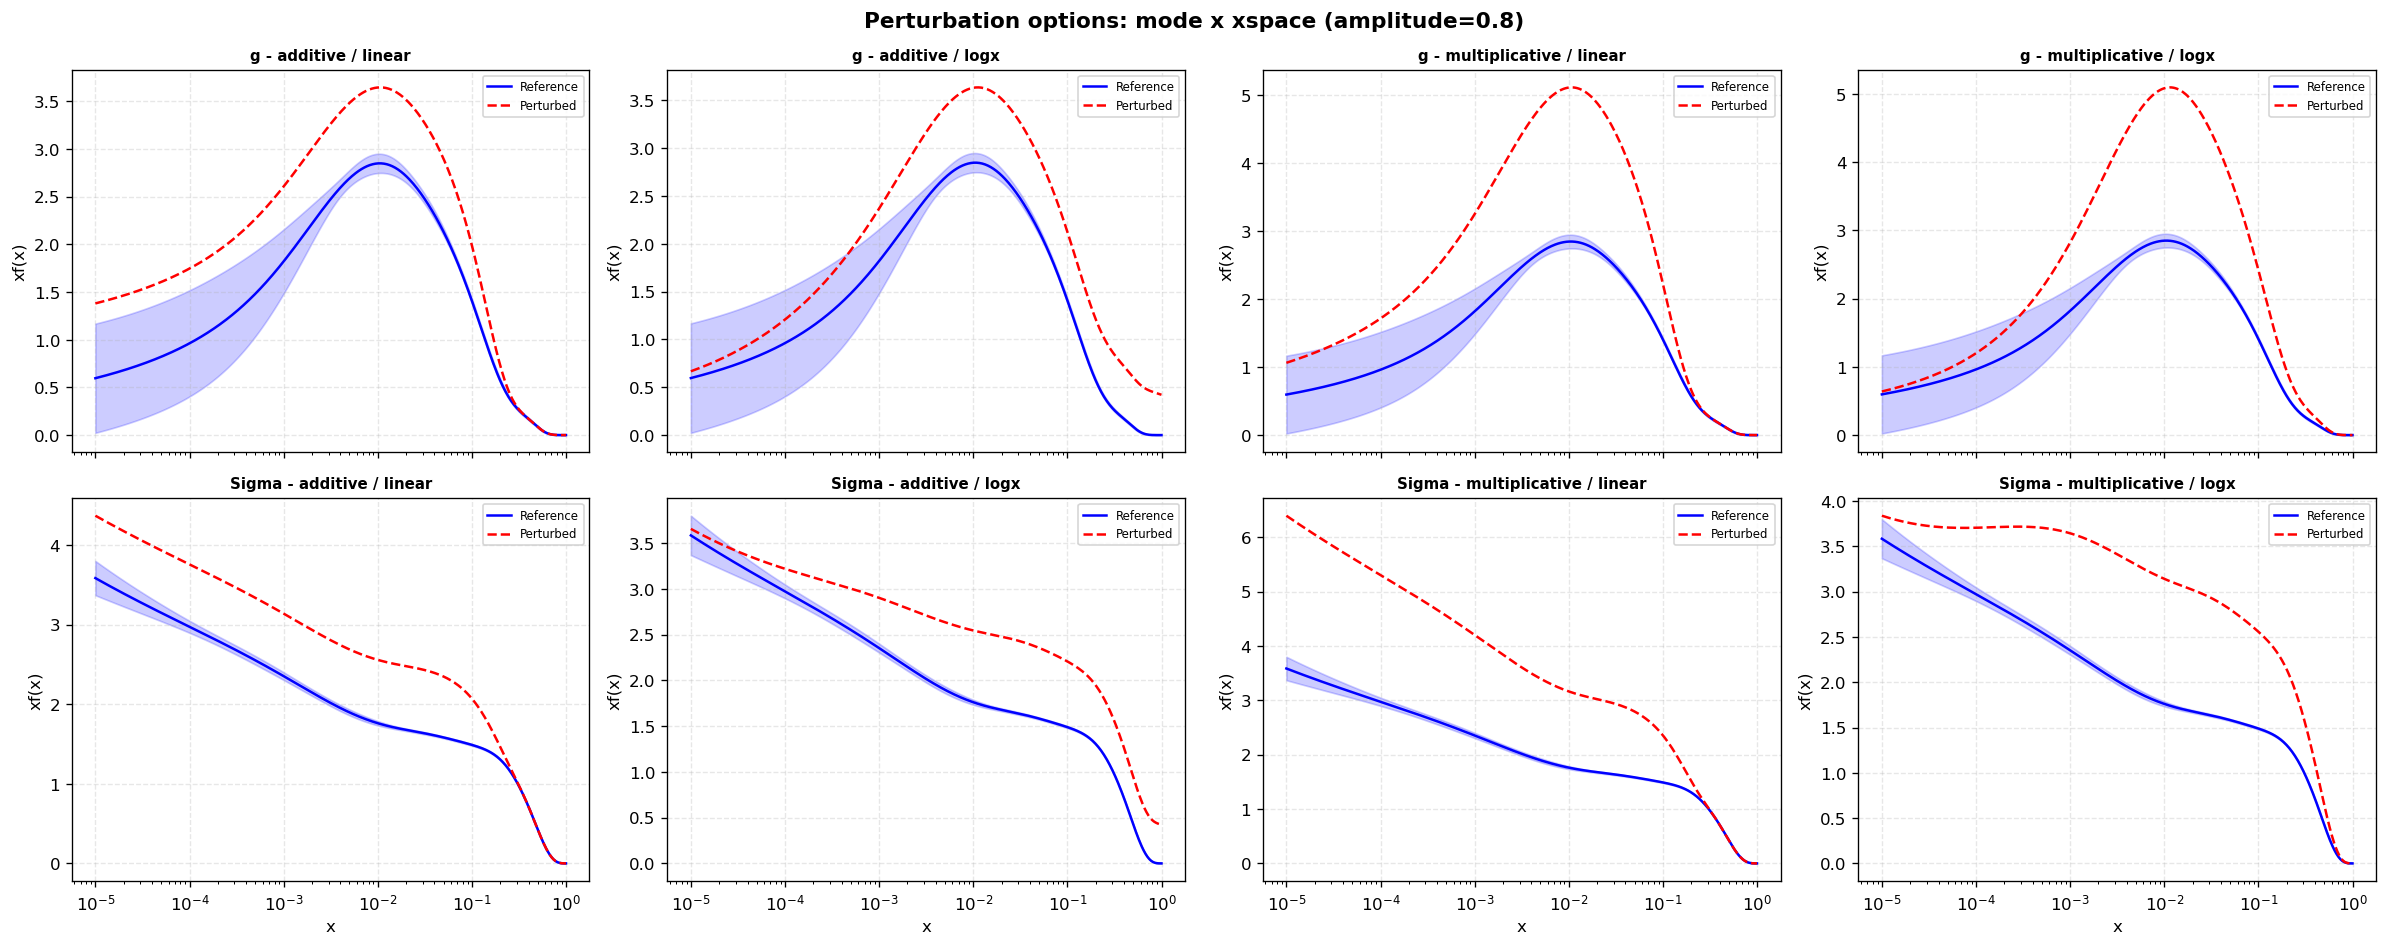


Relative perturbation at peak x-value:
------------------------------------------------------------
  additive        linear  g     : 29.5%  (at x=2.0e-02)
  additive        linear  Sigma : 47.7%  (at x=2.0e-02)
  additive        logx    g     : 29.5%  (at x=2.0e-02)
  additive        logx    Sigma : 47.7%  (at x=2.0e-02)
  multiplicative  linear  g     : 80.0%  (at x=2.0e-02)
  multiplicative  linear  Sigma : 80.0%  (at x=2.0e-02)
  multiplicative  logx    g     : 80.0%  (at x=2.0e-02)
  multiplicative  logx    Sigma : 80.0%  (at x=2.0e-02)
------------------------------------------------------------


In [30]:
import functools
from validphys.shapley.perturbation import gaussian_profile as _gaussian_profile
from validphys.pdfbases import evolution as evol_basis
from validphys.convolution import FK_FLAVOURS

# x grid and reference PDFs
x = np.logspace(-5, -0.001, 500)
Q0 = observables[0].Q0
gv_func = functools.partial(evol_basis.grid_values, pdf)
evol_names = FK_FLAVOURS[flavor_info['indices']]
gv_ref = gv_func(qmat=[Q0], vmat=evol_names, xmat=x).squeeze(-1)
gv_ref = gv_ref[1:101]  # 100 replicas

# 4 combinations of mode x xspace
combos = [
    ('additive',       'linear', dict(mu=0.02, sigma=0.1, amplitude=0.8)),
    ('additive',       'logx',   dict(mu=0.02, sigma=1.5, amplitude=0.8)),
    ('multiplicative', 'linear', dict(mu=0.02, sigma=0.1, amplitude=0.8)),
    ('multiplicative', 'logx',   dict(mu=0.02, sigma=1.5, amplitude=0.8)),
]

# Show gluon (idx 1) and Sigma (idx 0)
flavs_to_show = {'g': 1, 'Sigma': 0}

fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True)

for col, (mode, xspace, params) in enumerate(combos):
    gauss = _gaussian_profile(x, params['mu'], params['sigma'],
                              params['amplitude'], xspace)
    for row, (flav_label, flav_idx) in enumerate(flavs_to_show.items()):
        ax = axes[row, col]
        ref_mean = gv_ref[:, flav_idx, :].mean(axis=0)
        ref_std = gv_ref[:, flav_idx, :].std(axis=0)

        if mode == 'additive':
            pert_mean = ref_mean + gauss
        else:
            pert_mean = ref_mean * (1.0 + gauss)

        ax.plot(x, ref_mean, 'b-', lw=1.5, label='Reference')
        ax.fill_between(x, ref_mean - ref_std, ref_mean + ref_std,
                        alpha=0.2, color='blue')
        ax.plot(x, pert_mean, 'r--', lw=1.5, label='Perturbed')
        ax.set_xscale('log')
        ax.set_title(f'{flav_label} - {mode} / {xspace}', fontsize=9,
                      fontweight='bold')
        ax.grid(True, alpha=0.3, ls='--')
        ax.legend(fontsize=7)
        if row == 1:
            ax.set_xlabel('x')
        ax.set_ylabel('xf(x)')

fig.suptitle('Perturbation options: mode x xspace (amplitude=0.8)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Relative perturbation at peak for each combination
print("\nRelative perturbation at peak x-value:")
print("-" * 60)
for mode, xspace, params in combos:
    gauss = _gaussian_profile(x, params['mu'], params['sigma'],
                              params['amplitude'], xspace)
    peak_x_idx = np.argmax(gauss)
    for flav_label, flav_idx in flavs_to_show.items():
        ref_val = gv_ref[:, flav_idx, peak_x_idx].mean()
        if mode == 'additive':
            rel = gauss[peak_x_idx] / abs(ref_val) * 100
        else:
            rel = gauss[peak_x_idx] * 100
        print(f"  {mode:15s} {xspace:7s} {flav_label:6s}: "
              f"{rel:.1f}%  (at x={x[peak_x_idx]:.1e})")
print("-" * 60)